In [1]:
import pandas as pd
import io
import matplotlib.pyplot as plt
import nltk
nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn import metrics
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

In [3]:
from google.colab import files
uploaded = files.upload()

Saving drugsComTrain_raw.tsv to drugsComTrain_raw.tsv


In [5]:
from google.colab import files
uploaded = files.upload()

Saving drugsComTest_raw.tsv to drugsComTest_raw.tsv


In [4]:
train = pd.read_csv(io.BytesIO(uploaded['drugsComTrain_raw.tsv']), sep="\t")
train.head(2)

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192


In [6]:
test = pd.read_csv(io.BytesIO(uploaded['drugsComTest_raw.tsv']), sep="\t")
test.head(2)

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,"February 28, 2012",22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,"May 17, 2009",17


In [7]:
df = train.append(test)
df.columns = ["id", "drug", "condition", "review", "rating", "date", "useful"]
df.drop(["id"], axis=1, inplace=True)

In [8]:
print(df.dtypes)
print(df.isnull().sum())

drug          object
condition     object
review        object
rating       float64
date          object
useful         int64
dtype: object
drug            0
condition    1194
review          0
rating          0
date            0
useful          0
dtype: int64


In [9]:
df.dropna(inplace=True)

In [10]:
df.isnull().sum()

drug         0
condition    0
review       0
rating       0
date         0
useful       0
dtype: int64

In [11]:
print(df.shape)

(213869, 6)


In [12]:
blanks = []
for i, drug, cond, rv, rt, dt, usf in df.itertuples():
    if type(rv) == str:
        if rv.isspace():
            blanks.append(i)

In [13]:
blanks

[]

In [14]:
df['review'].replace(r'&#039;',"'", inplace=True, regex=True)

In [15]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

In [16]:
print(df.date.min())
print(df.date.max())

2008-02-24 00:00:00
2017-12-12 00:00:00


In [17]:
print(len(df.drug.value_counts()))
print(len(df.condition.value_counts()))

3667
916


In [18]:
df.drug.value_counts()[:30]

Levonorgestrel                        4896
Etonogestrel                          4402
Ethinyl estradiol / norethindrone     3619
Nexplanon                             2892
Ethinyl estradiol / norgestimate      2682
Ethinyl estradiol / levonorgestrel    2400
Phentermine                           2077
Sertraline                            1859
Escitalopram                          1739
Mirena                                1673
Implanon                              1506
Gabapentin                            1409
Bupropion                             1360
Miconazole                            1341
Venlafaxine                           1332
Citalopram                            1306
Medroxyprogesterone                   1273
Duloxetine                            1251
Lexapro                               1250
Bupropion / naltrexone                1241
Contrave                              1215
Metronidazole                         1205
Depo-Provera                          1155
Cymbalta   

In [19]:
df = df.groupby("drug").filter(lambda x: len(x) > 1400)

In [20]:
df.shape

(31154, 7)

In [21]:
for drug in df.drug.unique():
  t = df[df["drug"] == drug]
  print(f"The drug {drug} have these conditions:")
  print(t.condition.value_counts())
  print("\n")

The drug Levonorgestrel have these conditions:
Birth Control                2884
Emergency Contraception      1651
Abnormal Uterine Bleeding     355
Not Listed / Othe               6
Name: condition, dtype: int64


The drug Ethinyl estradiol / levonorgestrel have these conditions:
Birth Control                2107
Abnormal Uterine Bleeding     145
Endometriosis                  74
Ovarian Cysts                  33
Polycystic Ovary Syndrome      27
Premenstrual Syndrome          11
Not Listed / Othe               3
Name: condition, dtype: int64


The drug Nexplanon have these conditions:
Birth Control                                 2883
8</span> users found this comment helpful.       2
2</span> users found this comment helpful.       2
4</span> users found this comment helpful.       1
0</span> users found this comment helpful.       1
1</span> users found this comment helpful.       1
3</span> users found this comment helpful.       1
9</span> users found this comment helpful.       

In [22]:
df = df[~df["condition"].str.contains(r'</span>')]
df.shape

(31109, 7)

In [23]:
df.condition.value_counts()

Birth Control                            20262
Emergency Contraception                   1651
Weight Loss                               1650
Depression                                1178
Abnormal Uterine Bleeding                 1139
Anxiety                                    929
Generalized Anxiety Disorde                471
Acne                                       439
Obesity                                    396
Anxiety and Stress                         296
Panic Disorde                              271
Pain                                       239
Social Anxiety Disorde                     195
Endometriosis                              178
ibromyalgia                                151
Bipolar Disorde                            149
Obsessive Compulsive Disorde               140
Major Depressive Disorde                   129
Menstrual Disorders                        124
Peripheral Neuropathy                      121
Ovarian Cysts                              106
Polycystic Ov

In [24]:
df = df.groupby("condition").filter(lambda x: len(x) > 120)
df.shape

(30108, 7)

In [25]:
def sentiment(df):

  sid = SentimentIntensityAnalyzer()
  
  df["scores"] = df["review"].apply(lambda review: sid.polarity_scores(review))
  df["compound"] = df["scores"].apply(lambda d: d["compound"])
  df["comp_score"] = df["compound"].apply(lambda score: "positive" if score >= 0 else "negative")

In [26]:
sentiment(df)

In [27]:
df.rating.value_counts()

10.0    7855
9.0     4698
1.0     4095
8.0     3285
5.0     1990
7.0     1863
2.0     1823
3.0     1823
6.0     1340
4.0     1336
Name: rating, dtype: int64

In [28]:
df["rating_score"] = df["rating"].apply(lambda score: "positive" if score >= 7 else "negative")

In [29]:
df.drop(["scores", "compound"], axis=1, inplace= True)

In [30]:
print(metrics.confusion_matrix(df["rating_score"], df["comp_score"]))

[[ 8445  3962]
 [ 7268 10433]]


In [31]:
print(metrics.classification_report(df["rating_score"], df["comp_score"]))

              precision    recall  f1-score   support

    negative       0.54      0.68      0.60     12407
    positive       0.72      0.59      0.65     17701

    accuracy                           0.63     30108
   macro avg       0.63      0.64      0.63     30108
weighted avg       0.65      0.63      0.63     30108



In [32]:
random_indices = []

for i in range(0,19):
  n = random.randint(0, len(df))
  random_indices.append(n)

In [33]:
for review in random_indices: 
  print("Sentiment Analysis:", df.comp_score.iloc[review])
  print("Rating Score", df.rating_score.iloc[review])
  print(df.review.iloc[review])
  print("\n")

Sentiment Analysis: negative
Rating Score positive
"I've had Nexplanon for 2 years now and it has been wonderful. My doctor numbed my arm when I got it implanted so there was no physical pain. My arm was a tad sore after the numbing medication wore off, but only for a day or two at most. The soreness wasn't anything serious either. I didn't have any physical side effects from the implant at all. I did not gain weight, I did not get acne, my hair didn't get more oily, and I didn't cramp. After about a month of having it in, my period was due and I bled a little longer than usual. After bleeding for about 11 days, I spotted for about 7 more days. After that month of bleeding and spotting, I haven't had a period since. I am engaged and my fiance finished inside of me, I have not gotten pregnant"


Sentiment Analysis: positive
Rating Score positive
"I've been on Lexapro 10mg for 5 years now and it makes me &quot;me&quot; again.  It's wonderful! I've never had a side effect.  I've also lost

In [34]:
# 7/20 differents scores 
# 6/7 favouring rating score
# 1/7 favouring sentiment score

# Word ambiguity and negation detection

In [35]:
def LDA(df, n_components, min_df, max_df):

  cv = CountVectorizer(min_df=min_df, max_df=max_df, stop_words="english")
  dtm = cv.fit_transform(df["review"])
  LDA = LatentDirichletAllocation(n_components=n_components).fit(dtm)

  for index, topic in enumerate(LDA.components_):
    print(f"THE TOP 20 WORDS FOR TOPIC #{index}")
    print([cv.get_feature_names()[i] for i in topic.argsort()[-20:]])
    print("\n")

In [36]:
def NNMF(df, n_components, min_df, max_df):

  tfidf = TfidfVectorizer(min_df=min_df, max_df=max_df, stop_words="english")
  dtm = tfidf.fit_transform(df["review"])
  nmf_model = NMF(n_components=n_components).fit(dtm)

  for index, topic in enumerate(nmf_model.components_):
    print(f"THE TOP 20 WORDS FOR TOPIC #{index}")
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-20:]])
    print("\n")

In [37]:
df.condition.value_counts()

Birth Control                   20262
Emergency Contraception          1651
Weight Loss                      1650
Depression                       1178
Abnormal Uterine Bleeding        1139
Anxiety                           929
Generalized Anxiety Disorde       471
Acne                              439
Obesity                           396
Anxiety and Stress                296
Panic Disorde                     271
Pain                              239
Social Anxiety Disorde            195
Endometriosis                     178
ibromyalgia                       151
Bipolar Disorde                   149
Obsessive Compulsive Disorde      140
Major Depressive Disorde          129
Menstrual Disorders               124
Peripheral Neuropathy             121
Name: condition, dtype: int64

In [38]:
LDA(df.loc[(df["rating_score"] == "negative")], 12, 3, 0.6)

THE TOP 20 WORDS FOR TOPIC #0
['years', 'spotting', 'like', 'bad', 'got', 'days', 'bleeding', 'removed', 'weeks', 'day', 'skyla', 'cramps', 'inserted', 'painful', 'rsquo', 'iud', 'pain', 'cramping', 'insertion', 'mirena']


THE TOP 20 WORDS FOR TOPIC #1
['stomach', 'feeling', 'pills', 'just', 'having', 'bad', 'sprintec', 'night', 'pack', 'started', 'time', 'years', 'like', 'nausea', 'stopped', 'bleeding', 'months', 've', 'month', 'taking']


THE TOP 20 WORDS FOR TOPIC #2
['weight', 'swings', 'time', 'depression', 'getting', 'years', 'mood', 'year', 'bleeding', 've', 'control', 'birth', 'effects', 'got', 'implanon', 'having', 'implant', 'removed', 'nexplanon', 'months']


THE TOP 20 WORDS FOR TOPIC #3
['inserted', 'lower', 'ago', 'horrible', 'went', 'day', 'mirena', 've', 'got', 'days', 'don', 'doctor', 'felt', 'insertion', 'bad', 'cramps', 'just', 'like', 'feel', 'pain']


THE TOP 20 WORDS FOR TOPIC #4
['test', 'didn', 'time', 'pregnancy', 'just', 'work', 'went', 'got', 'later', 'perio

In [39]:
NNMF(df.loc[(df["rating_score"] == "negative")], 12, 3, 0.6)

THE TOP 20 WORDS FOR TOPIC #0
['pack', 'second', 'time', 'normal', 'day', 'just', 'lasted', 'months', 'periods', 'got', 'light', 'cramps', 'heavy', 'started', 'weeks', 'week', 'spotting', 'days', 'month', 'period']


THE TOP 20 WORDS FOR TOPIC #1
['blood', 'breakthrough', 'inserted', 'constant', 'started', 'bled', 'spotting', 'week', 'straight', 'day', 'doctor', 'bleed', 'days', 'weeks', 'non', 'stopped', 'heavy', 'months', 'stop', 'bleeding']


THE TOP 20 WORDS FOR TOPIC #2
['inserted', 'horrible', 'periods', 'thing', '2015', 'years', 'time', 'arm', 'year', 'pregnant', 'months', 'having', 'getting', 'removed', 'implanon', 'swings', 'mood', 'implant', 'nexplanon', 'got']


THE TOP 20 WORDS FOR TOPIC #3
['attacks', 'don', 'really', 'sleep', 'better', 'zoloft', 'panic', 'time', 'effects', 'feeling', 'medication', 'started', 'just', 'day', 'depression', 'felt', 'taking', 'like', 'feel', 'anxiety']


THE TOP 20 WORDS FOR TOPIC #4
['effective', 'controls', 'time', 'mood', 'switched', 'diffe

In [40]:
# LDA more meaningful outputs

In [41]:
negative = df.loc[(df["rating_score"] == "negative")]
positive = df.loc[(df["rating_score"] == "positive")]

In [42]:
cv = CountVectorizer(min_df=3, max_df=0.7, stop_words="english")
dtm = cv.fit_transform(negative["review"])
LDA = LatentDirichletAllocation(n_components=12).fit(dtm)

for index, topic in enumerate(LDA.components_):
  print(f"THE TOP 20 WORDS FOR TOPIC #{index}")
  print([cv.get_feature_names()[i] for i in topic.argsort()[-20:]])
  print("\n")

THE TOP 20 WORDS FOR TOPIC #0
['don', 'just', 'diet', 'eating', 'years', 'getting', 'eat', 'lost', 'lose', 'year', 'got', 'lbs', 'birth', 'control', 'months', 've', 'pounds', 'gain', 'gained', 'weight']


THE TOP 20 WORDS FOR TOPIC #1
['getting', 'pregnancy', 'life', 'sex', 'having', 'depressed', 'swings', 'pill', 'took', 'got', 'just', 'time', 'pregnant', 'mood', 've', 'don', 'like', 'feel', 'birth', 'control']


THE TOP 20 WORDS FOR TOPIC #2
['bad', 'sprintec', 'just', 'years', 'swings', 'effects', 'tri', 'skin', 'mood', 'week', 'switched', 'started', 'month', 'months', 'taking', 'birth', 'control', 'pill', 'acne', 've']


THE TOP 20 WORDS FOR TOPIC #3
['hair', 'gained', 'time', 'nexplanon', 'having', 'acne', 'got', 'years', 'year', 'gain', 'removed', 'periods', 'implanon', 'months', 'weight', 've', 'drive', 'swings', 'mood', 'sex']


THE TOP 20 WORDS FOR TOPIC #4
['blood', 'stop', 'pill', 'cramps', 'week', 'spotting', 'started', 'having', 'inserted', 've', 'day', 'weeks', 'mirena', 

In [43]:
topic_results = LDA.transform(dtm) 

negative["Topic"] = topic_results.argmax(axis=1)

topics_dictionary = {0: "pressure_heart_energy", 1: "spotting_bleeding", 
                     2: "mood_skin_acne", 3: "cramps_painful", 4: "weight_hair",
                     5: "mood_weight", 6: "spotting_bleading", 7: "pannics_attacks", 
                     8: "painful", 9: "bleeding_weight",
                     10: "anxiety_depression", 11: "swings_mood"}

negative["Topic_Label"] = negative["Topic"].map(topics_dictionary)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [44]:
cv = CountVectorizer(min_df=3, max_df=0.3, stop_words="english")
dtm = cv.fit_transform(positive["review"])
LDA = LatentDirichletAllocation(n_components=5).fit(dtm)

for index, topic in enumerate(LDA.components_):
  print(f"THE TOP 20 WORDS FOR TOPIC #{index}")
  print([cv.get_feature_names()[i] for i in topic.argsort()[-20:]])
  print("\n")

THE TOP 20 WORDS FOR TOPIC #0
['lose', 'diet', 'month', 'just', 'exercise', 'dry', 'eating', 'mouth', 'water', 'pill', 'days', 'phentermine', 'day', 'week', 'eat', 'taking', 'pounds', 'lbs', 'started', 'lost']


THE TOP 20 WORDS FOR TOPIC #1
['great', 'got', 'year', 'days', 'haven', 'started', 'time', 'sex', 'years', 'swings', 'taking', 'effects', 'gain', 'mood', 'periods', 'acne', 'month', 'birth', 'control', 'pill']


THE TOP 20 WORDS FOR TOPIC #2
['effects', 'unprotected', 'condom', 'did', 'like', 'pregnant', 'didn', 'came', 'week', 'time', 'later', 'just', 'hours', 'sex', 'plan', 'got', 'day', 'days', 'pill', 'took']


THE TOP 20 WORDS FOR TOPIC #3
['day', 'bad', 'painful', 'control', 'love', 'cramping', 'days', 'birth', 'cramps', 'periods', 'like', 'bleeding', 'just', 'spotting', 'pain', 'inserted', 'years', 'got', 'mirena', 'insertion']


THE TOP 20 WORDS FOR TOPIC #4
['time', 'panic', 'pain', 'mg', 'felt', 'medication', 'better', 'zoloft', 'weeks', 'started', 'like', 'years', 'l

In [45]:
topic_results = LDA.transform(dtm) 

positive["Topic"] = topic_results.argmax(axis=1)

topics_dictionary = {0: "only_drink_water", 1: "liking_love", 
                     2: "works", 3: "better", 4: "great"}
                  
positive["Topic_Label"] = positive["Topic"].map(topics_dictionary)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [46]:
df = positive.append(negative)

In [47]:
df.head(2)

,drug,condition,review,rating,date,useful,year,comp_score,rating_score,Topic,Topic_Label
9,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8.0,2016-12-08,1,2016,negative,positive,1,liking_love
22,Etonogestrel,Birth Control,"""Nexplanon does its job. I can have worry free...",9.0,2014-08-11,11,2014,positive,positive,1,liking_love


In [48]:
x = df["review"]
y = df["rating_score"]

In [49]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

In [50]:
text_clf = Pipeline([("tfidf", TfidfVectorizer()), ("clf", LogisticRegression())]).fit(x_train, y_train)
predictions = text_clf.predict(x_test)
print(metrics.confusion_matrix(y_test, predictions))
print(metrics.classification_report(y_test, predictions))

[[1953  533]
 [ 434 3102]]
              precision    recall  f1-score   support

    negative       0.82      0.79      0.80      2486
    positive       0.85      0.88      0.87      3536

    accuracy                           0.84      6022
   macro avg       0.84      0.83      0.83      6022
weighted avg       0.84      0.84      0.84      6022



In [51]:
new_review = "I have been taking for one month the medicine and I feel better, Relief after all the pains and problems"
text_clf.predict([new_review])

array(['positive'], dtype=object)

In [52]:
df.drop(["date", "review", "useful", "Topic", "rating", "comp_score"], axis=1, inplace=True)

In [57]:
df.head(2)

,drug,condition,year,rating_score,Topic_Label
9,Ethinyl estradiol / levonorgestrel,Birth Control,2016,positive,liking_love
22,Etonogestrel,Birth Control,2014,positive,liking_love


In [76]:
levonorgestrel = df[df["drug"]=="Levonorgestrel"]
etonogestrel = df[df["drug"]=="Etonogestrel"]
ethinyl_norethindrone = df[df["drug"]=="Ethinyl estradiol / norethindrone"]
nexplanon = df[df["drug"]=="Nexplanon"]
ethinyl_norgestimate = df[df["drug"]=="Ethinyl estradiol / norgestimate"]
eginyl_levonorgestrel = df[df["drug"]=="Ethinyl estradiol / levonorgestrel"]
phentermine = df[df["drug"]=="Phentermine"]
sertraline = df[df["drug"]=="Sertraline"]
escitalopram = df[df["drug"]=="Escitalopram"]
mirena = df[df["drug"]=="Mirena"]
implanon = df[df["drug"]=="Implanon"]
gabapentin = df[df["drug"]=="Gabapentin"]

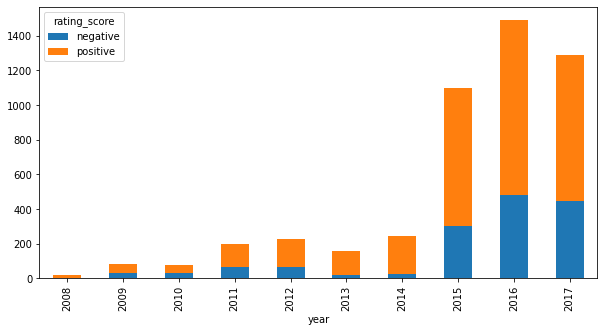

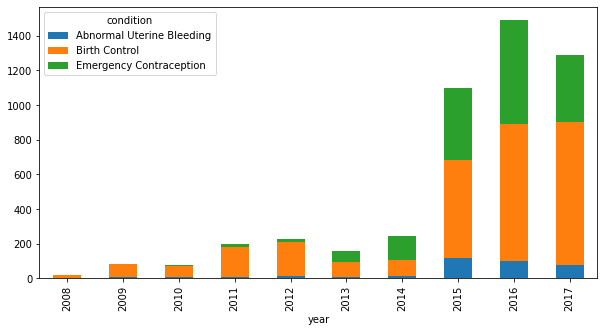

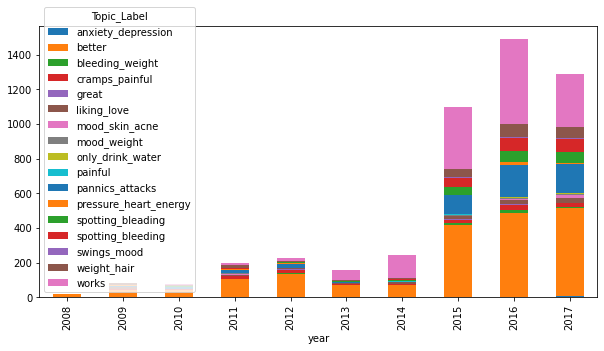

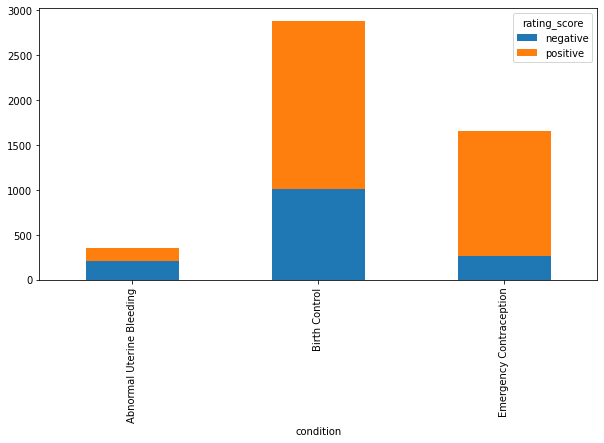

In [75]:
pd.crosstab(levonorgestrel["year"], levonorgestrel["rating_score"]).plot(kind="bar", stacked=True, figsize=(10,5));
pd.crosstab(levonorgestrel["year"], levonorgestrel["condition"]).plot(kind="bar", stacked=True, figsize=(10,5));
pd.crosstab(levonorgestrel["year"], levonorgestrel["Topic_Label"]).plot(kind="bar", stacked=True, figsize=(10,5));
pd.crosstab(levonorgestrel["condition"], levonorgestrel["rating_score"]).plot(kind="bar", stacked=True, figsize=(10,5));

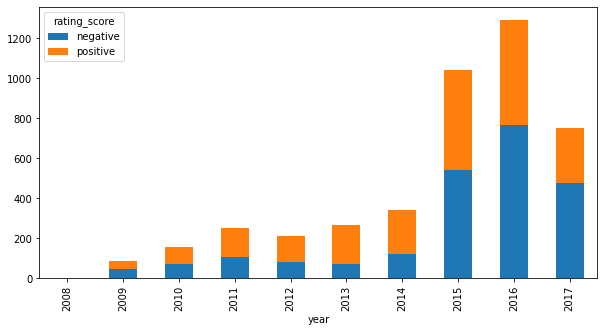

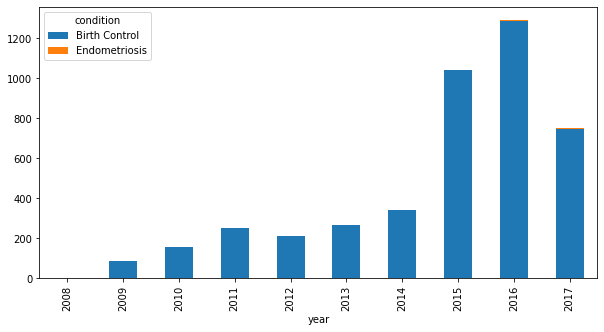

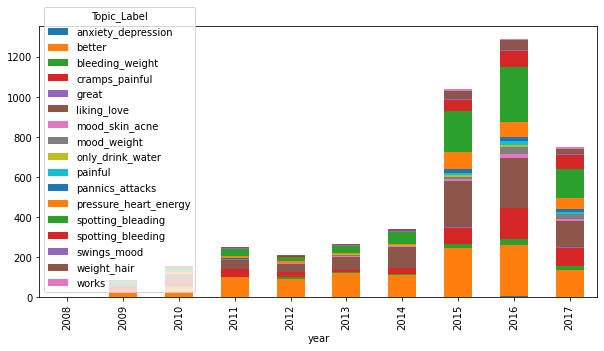

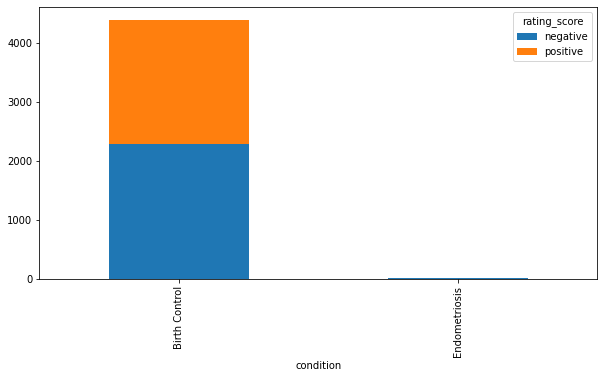

In [77]:
pd.crosstab(etonogestrel["year"], etonogestrel["rating_score"]).plot(kind="bar", stacked=True, figsize=(10,5));
pd.crosstab(etonogestrel["year"], etonogestrel["condition"]).plot(kind="bar", stacked=True, figsize=(10,5));
pd.crosstab(etonogestrel["year"], etonogestrel["Topic_Label"]).plot(kind="bar", stacked=True, figsize=(10,5));
pd.crosstab(etonogestrel["condition"], etonogestrel["rating_score"]).plot(kind="bar", stacked=True, figsize=(10,5));

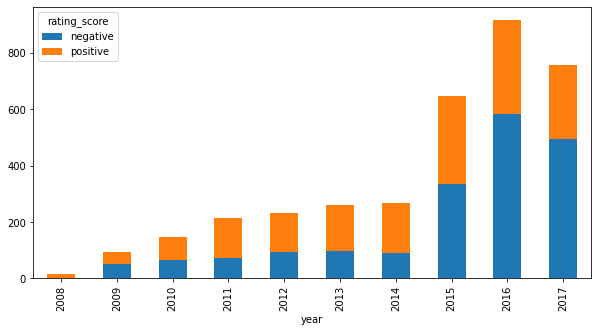

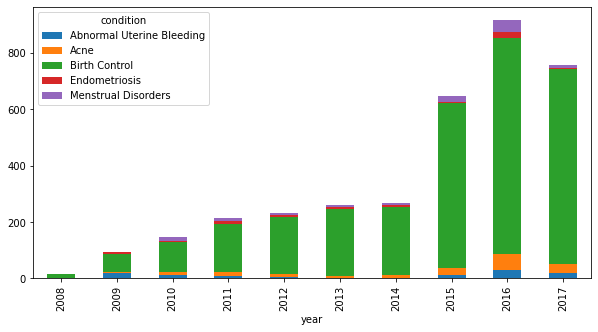

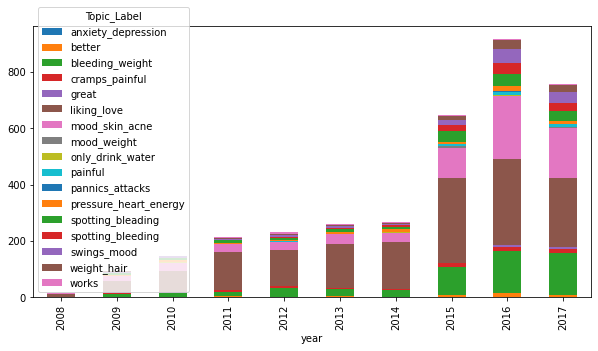

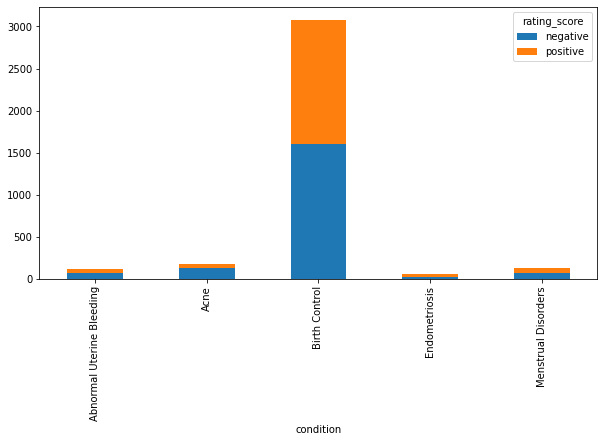

In [78]:
pd.crosstab(ethinyl_norethindrone["year"], ethinyl_norethindrone["rating_score"]).plot(kind="bar", stacked=True, figsize=(10,5));
pd.crosstab(ethinyl_norethindrone["year"], ethinyl_norethindrone["condition"]).plot(kind="bar", stacked=True, figsize=(10,5));
pd.crosstab(ethinyl_norethindrone["year"], ethinyl_norethindrone["Topic_Label"]).plot(kind="bar", stacked=True, figsize=(10,5));
pd.crosstab(ethinyl_norethindrone["condition"], ethinyl_norethindrone["rating_score"]).plot(kind="bar", stacked=True, figsize=(10,5));